0 6
      known  labels  distance  predictions  label  correct  \
0     False   -1000  4.556574            0  -1000    False   
1     False   -1000  6.269236            3  -1000    False   
2     False   -1000  4.180768            3  -1000    False   
3      True       9  0.143143            9      9     True   
4      True       1  0.367708            1      1     True   
...     ...     ...       ...          ...    ...      ...   
9995  False   -1000  5.453350            2  -1000    False   
9996  False   -1000  7.289058            0  -1000    False   
9997  False   -1000  5.506842            3  -1000    False   
9998   True       9  0.279514            9      9     True   
9999   True       2  0.156246            2      2     True   

                       Group  
0                    Anomaly  
1                    Anomaly  
2                    Anomaly  
3     Inlier (Correct Class)  
4     Inlier (Correct Class)  
...                      ...  
9995                 Anomaly  
999

<ipython-input-1-5fc82f1ef5eb>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta["Group"][df_meta["known"] & df_meta["correct"]] = "Inlier (Correct Class)"


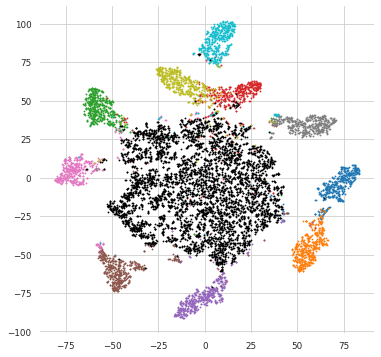

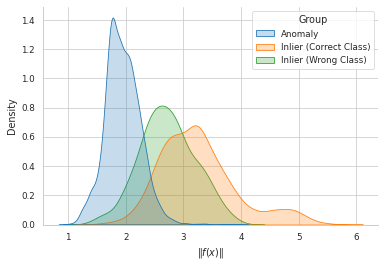

/home/ki/.local/share/anaconda3/envs/mchad/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


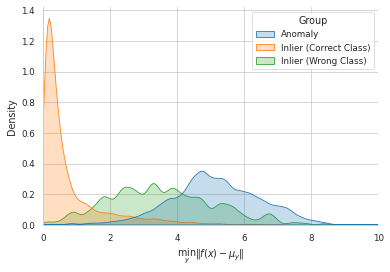

In [1]:
"""
experiment=cifar10-gmchad trainer.gpus=1 dataset_dir=/home/ki/datasets/ ++model.pretrained_checkpoint='${data_dir}/imagenet_wrn_baseline_epoch_99.pt' callbacks=mchad_embeds.yaml
"""

import seaborn as sb
import matplotlib.pyplot as plt

sb.set()
sb.set_style("whitegrid")
sb.set_context("paper")
import pandas as pd
from os.path import join
from sklearn.manifold import TSNE
from scipy.linalg import norm
from pytorch_ood.utils import is_known


root = "/home/ki/projects/work/mchad/logs/"
path = join(root, "runs/18-45-46/")
# /home/ki/projects/work/mchad/logs/multiruns/complete/missing/12/09/21-16:26:33/cifar10/gmchad/0/tb/version_0/15680/test-1/
# home/ki/projects/work/mchad//tb/version_0/
for c in range(1):
    for i in [6]:
        print(c, i)
        p = join(path, f"tb/version_0/03920/images-test-{i}/")
        df = pd.read_csv(join(p, "tensors.tsv"), delimiter="\t", header=None)
        df_meta = pd.read_csv(join(p, "metadata.tsv"), delimiter="\t", header=0)
        df_meta["label"] = df_meta["labels"]

        df_meta["known"] = is_known(df_meta["labels"])
        df_meta["correct"] = df_meta["labels"] == df_meta["predictions"]

        df_meta["Group"] = 0
        df_meta["Group"][df_meta["known"] & df_meta["correct"]] = "Inlier (Correct Class)"
        df_meta["Group"][df_meta["known"] & ~df_meta["correct"]] = "Inlier (Wrong Class)"
        df_meta["Group"][~df_meta["known"]] = "Anomaly"

        print(df_meta)
        pca = TSNE()
        x = pca.fit_transform(df.values)

        sb.set_palette(sb.color_palette("tab10"))

        fix = plt.figure(figsize=(6, 6))
        for label in df_meta["label"].unique():
            if label < 0:
                continue
            idx = df_meta["label"] == label
            plt.scatter(x[idx, 0], x[idx, 1], label=label, s=1)

        idx = df_meta["label"] < 0
        plt.scatter(x[idx, 0], x[idx, 1], label=-1, s=1, color="black")
        sb.despine(left=True, bottom=True)
        plt.show()
        # plt.savefig("out/latent-cifar-lsun-resize.pgf")
        # plt.legend()

        norms = norm(df.values, ord=2, axis=1)
        label = pd.Series(
            data=(df_meta["label"] >= 0).apply({True: "Normal", False: "Anomaly"}.get),
            name="Label",
        )

        sb.kdeplot(x=norms, hue=df_meta["Group"], common_norm=False, fill=True)
        plt.xlabel("$\Vert f(x) \Vert $")
        sb.despine()
        plt.savefig("out/density_norm.pgf")
        plt.show()
        # df_meta["dist_e"] = np.log(df_meta["distance"])

        ax = sb.kdeplot(
            x=df_meta["distance"], hue=df_meta["Group"], common_norm=False, fill=True, bw=0.1
        )
        plt.xlabel("$\min_y \Vert f(x) - \mu_y \Vert$")
        # ax.legend_._set_loc(2)
        # plt.xlim([0.0, 1.3])
        plt.xlim([0, 10])
        sb.despine()

        # plt.legend(loc="upper right")
        plt.savefig("out/density_distance.pgf")
        plt.show()